In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import pickle
import os

In [2]:
data = pd.read_excel("/content/employee_burnout_analysis-AI.xlsx")

In [3]:
# Display unique values for object columns
data_obj = data.select_dtypes(object)
pprint({c: data_obj[c].unique()[:10] for c in data_obj.columns})

# Drop irrelevant columns
data = data.drop('Employee ID', axis=1)

{'Company Type': array(['Service', 'Product'], dtype=object),
 'Employee ID': array(['fffe32003000360033003200', 'fffe3700360033003500',
       'fffe31003300320037003900', 'fffe32003400380032003900',
       'fffe31003900340031003600', 'fffe3300350037003500',
       'fffe33003300340039003100', 'fffe32003600320037003400',
       'fffe32003200300034003700', 'fffe31003600320030003200'],
      dtype=object),
 'Gender': array(['Female', 'Male'], dtype=object),
 'WFH Setup Available': array(['No', 'Yes'], dtype=object)}


In [4]:
# Print min and max dates
print(f"Min date: {data['Date of Joining'].min()}")
print(f"Max date: {data['Date of Joining'].max()}")

Min date: 2008-01-01 00:00:00
Max date: 2008-12-31 00:00:00


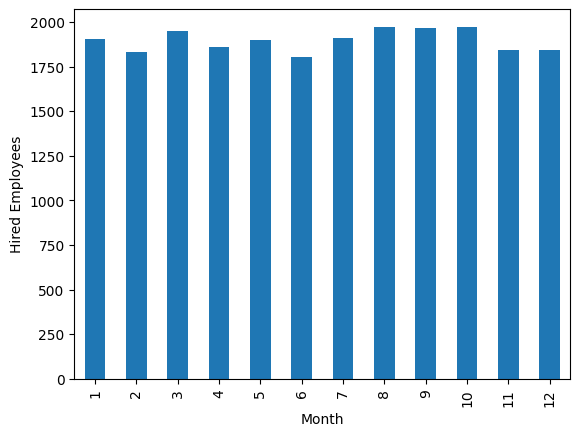

In [5]:
# Convert Date of Joining to datetime
data['Date of Joining'] = pd.to_datetime(data['Date of Joining'])

# Extract month from Date of Joining
data['Joining Month'] = data['Date of Joining'].dt.month

# Plot the number of employees hired each month
data['Joining Month'].value_counts().sort_index().plot(kind='bar', xlabel='Month', ylabel='Hired Employees')

# Assume 'Burn Rate' is the target variable
target = 'Burn Rate'

In [6]:
# Check for missing values
print(data.isnull().sum())

Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
Joining Month              0
dtype: int64


In [7]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [8]:
# Convert 'Date of Joining' to numerical representation (e.g., ordinal)
data['Date of Joining'] = data['Date of Joining'].apply(lambda x: x.toordinal())

# Apply Iterative Imputer to fill missing values
imputer = IterativeImputer(random_state=42)
data_imputed = imputer.fit_transform(data)

In [9]:
# Convert the imputed numpy array back to a DataFrame
data = pd.DataFrame(data_imputed, columns=data.columns)

In [10]:
# Detect and handle outliers using z-score
z_scores = np.abs(stats.zscore(data))
data = data[(z_scores < 3).all(axis=1)]

In [11]:
# Split the data into features and target
X = data.drop(columns=[target])
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
y_train

19869    0.28
18157    0.39
21225    0.37
19516    0.32
8973     0.53
         ... 
12067    0.60
21744    0.44
5437     0.33
868      0.51
15928    0.35
Name: Burn Rate, Length: 18063, dtype: float64

In [13]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
# Make predictions
y_pred = rf.predict(X_test)

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.0029001181384998203
Mean Absolute Error: 0.04224676756201492
R^2 Score: 0.9219164930098694


In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Multi-layer Perceptron Regressor": MLPRegressor(),
    "Linear Support Vector Regressor": LinearSVR(),
    "Support Vector Regressor": SVR(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "LightGBM Regressor": LGBMRegressor(),
}

In [18]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} evaluation:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print("-" * 30)


    # Plotting predicted vs actual values
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, edgecolors='k', alpha=0.7, label='Predictions', color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} - Predicted vs Actual Values')
    plt.legend()
    plt.show()

    # Plotting residuals
    plt.figure(figsize=(12, 6))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, edgecolors='k', alpha=0.7, label='Residuals', color='green')
    plt.axhline(y=0, color='red', linestyle='--', lw=2, label='Zero Error')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residuals')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.